In [179]:
import random
import numpy as np
from tqdm import tqdm
import torch as T
import torch.nn as nn

import matplotlib.pyplot as plt

import unicodedata
from glob import glob
from collections import defaultdict

from torch.utils.data import Dataset, DataLoader

In [201]:
glob('names/*.txt')

['names\\Arabic.txt',
 'names\\Chinese.txt',
 'names\\Czech.txt',
 'names\\Dutch.txt',
 'names\\English.txt',
 'names\\French.txt',
 'names\\German.txt',
 'names\\Greek.txt',
 'names\\Irish.txt',
 'names\\Italian.txt',
 'names\\Japanese.txt',
 'names\\Korean.txt',
 'names\\Polish.txt',
 'names\\Portuguese.txt',
 'names\\Russian.txt',
 'names\\Scottish.txt',
 'names\\Spanish.txt',
 'names\\Vietnamese.txt']

In [2]:
EOS_TOKEN = 27 #end of string

char_to_code = defaultdict(int)
for c in range(97, 97 + 26):
    char_to_code[chr(c)] = c - 97 + 1

def prepare_txt(s):
    return unicodedata.normalize('NFKD', s.split('\n')[0]).\
            encode('ASCII', 'ignore').lower().decode()

def str_to_code(s):
    return list(map(lambda x: char_to_code[x], s)) + [EOS_TOKEN]

In [ ]:
#char_to_code

In [259]:
def shuffle_return(L):
    L = [v for v in L] #copy
    random.Random(23).shuffle(L)
    return L

class NamesDataset(Dataset):
    def __init__(self, filename=None, train=True):
        """filname : if None, then load all the files. 
           train : if True, then buil train dataset else test dataset
        """
        if filename:
            all_files = open(filename, encoding="utf-8") 
            data = list(map(lambda s: str_to_code(prepare_txt(s)), all_files))
            y = list(range(len(data)))
            data_y = [0] * len(data)#[[y[i]] * len(d) for i, d in enumerate(data)]
            #data_y = [val for sublist in data_y for val in sublist]
        else: 
            all_files = [open(f, encoding="utf-8") for f in glob('names/*.txt')]
            data = [list(map(lambda s: str_to_code(prepare_txt(s)), f)) 
                    for f in all_files]
            data = [shuffle_return(v) for v in data]
            max_len = min(map(len, data))
            data = [v[:max_len * 2] for v in data]
            y = list(range(len(data)))
            data_y = [ [y[i]]*len(d)   for i, d in enumerate(data)]
            data_y = [val for sublist in data_y for val in sublist]
            data = [val for sublist in data for val in sublist]
        self.classes = all_files  
        z = list(zip(data, data_y))
        random.Random(4).shuffle(z)
        data, data_y = np.array(list(zip(*z)))
        self.data_x = data#data[:int(len(data) * .8)] if train else data[int(len(data) * .8):]
        self.data_y = data_y#data_y[:int(len(data_y) * .8)] if train else data_y[int(len(data_y) * .8):]
                
    def __getitem__(self, index):  #ds[5]
        return T.tensor(self.data_x[index]), self.data_y[index]

    def __len__(self):
        return len(self.data_x)

def collate_fn(data):
    maximum = max(list(map(lambda x: len(x[0]), data)))
    return T.tensor(list(map(lambda d: list(d[0])+(maximum-len(d[0]))*[EOS_TOKEN], data))), list(zip(*data))[1]

In [260]:
ds = NamesDataset()#filename="names\\French.txt")
ds_test = NamesDataset()#filename="names\\French.txt", train=False)
#ds = NamesDataset(None)
dl = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(ds_test, batch_size=1, collate_fn=collate_fn)

In [261]:
def one_hot_char(x, char_to_code):
    embd = [0]*(len(set(char_to_code.values())) + 1)
    embd[x] = 1
    return embd

def one_hot_string(seq, char_to_code):
    res = []
    for x in seq: 
        res.append(one_hot_char(x, char_to_code))
    return res

def one_hot_batch(x_batch):
    res = []
    for i, _ in enumerate(x_batch):
        res.append(one_hot_string(x_batch[i], char_to_code))
    return T.tensor(res).float()         

In [266]:
class GCORnn(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, category_size):
        super(GCORnn, self).__init__() 
        self.hidden_size = hidden_size
        self.nb_layer = 3
        self.input_size = input_size #28
        self.output_size = output_size #28
        
        self.i2h = nn.Linear(self.hidden_size + self.input_size + category_size , self.hidden_size)
        #self.i2o = nn.Linear(self.hidden_size + self.input_size + category_size, self.output_size)
        self.i2o = nn.Sequential(
            nn.Linear(self.hidden_size + self.input_size + category_size, self.output_size),
            nn.BatchNorm1d(self.output_size),
            nn.ReLU(),
            nn.Dropout(.30),
            nn.Linear(self.output_size, self.output_size),
            nn.Dropout(.60),
        )
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
      
    def forward(self, category, input_x, hidden):
        x = T.cat((category, input_x, hidden), 1)
        hidden = self.relu(self.i2h(x))
        output = self.softmax(self.i2o(x))
        return output, hidden

    def init_hidden(self, batch_size=1):
        return T.zeros(batch_size, self.hidden_size)   




  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



  1%|          | 1/100 [00:02<04:38,  2.81s/it]


  2%|▏         | 2/100 [00:05<04:35,  2.81s/it]


  3%|▎         | 3/100 [00:08<04:28,  2.77s/it]


  4%|▍         | 4/100 [00:11<04:45,  2.97s/it]


  5%|▌         | 5/100 [00:14<04:37,  2.92s/it]


  6%|▌         | 6/100 [00:17<04:33,  2.91s/it]


  7%|▋         | 7/100 [00:20<04:31,  2.92s/it]


  8%|▊         | 8/100 [00:23<04:30,  2.94s/it]


  9%|▉         | 9/100 [00:27<04:33,  3.00s/it]


 10%|█         | 10/100 [00:30<04:32,  3.03s/it]


 11%|█         | 11/100 [00:33<04:30,  3.04s/it]


 12%|█▏        | 12/100 [00:36<04:25,  3.01s/it]


 13%|█▎        | 13/100 [00:38<04:20,  3.00s/it]


 14%|█▍        | 14/100 [00:41<04:15,  2.98s/it]


 15%|█▌        | 15/100 [00:44<04:14,  3.00s/it]


 16%|█▌  

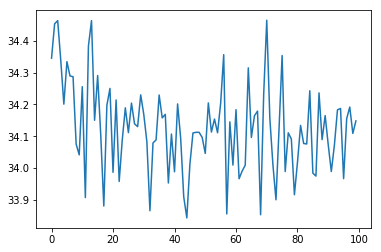

In [267]:
from tqdm import trange


rnn = GCORnn(input_size=28, output_size=28, hidden_size=128, category_size=18)
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.MSELoss()
hidden = rnn.init_hidden()
optimizer = T.optim.SGD(rnn.parameters(), lr=1e-2)
epochs = 100

train_history, test_history = [], []
train_acc, test_acc = [], []
for epoch in trange(epochs):
    batch_history = []
    batch_acc = []
    for x, y in dl:
        hidden  = rnn.init_hidden(batch_size=x.shape[0])
        # s.shape[0] = batch_size
        output  = T.zeros(x.shape[0], 28) 
        output[:, 0] = 1. #the first char given as input to our generative model
        outputs = T.zeros((x.shape[1], x.shape[0], 28))

        optimizer.zero_grad()
        
        input_x = one_hot_batch(x)
        for i in range(x.shape[1]):
            #convert y to category (onehot)
            category = T.zeros((x.shape[0], 18))
            category[:, y] = 1.

            #pass the word throught the network
            output, hidden = rnn(category, output, hidden)
            outputs[i] = output

        #calcul du mask
        
        
        # output = a + b, tel que a = 1 si xi != 27, 0 sinon
        #b = 1 si xi == 27, 0 sinon
        #print(x.shape, x.shape[0], x.shape[1])
        mask = (x != 27).float().unsqueeze(-1).expand(x.shape[0], x.shape[1], 28)
        mask = mask.permute(1, 0, 2)
        #print(mask.shape, outputs.shape)
        a = mask * outputs 
        b = T.zeros(mask.shape)
        b[:, :, -1] = 1. #on cree une matrice avec 1 partout sur la derniere profondeur
        b *= (1 - mask) # on garde juste la ou y'a 27 à la fin 
        masked_outputs = a + b
        masked_outputs = masked_outputs.permute(1, 0, 2)
        
        #le caractere ajouté 
        #print(x.shape, masked_outputs.shape)
        
        #get the final prediction for each word
        #yhat = (m * outputs).sum(dim=0)
        #print(masked_outputs.shape, input_x.shape)
        #compute loss
        loss = sum([loss_function(masked_outputs[:, i], x[:, i]) for i in range(x.shape[1])])
        #loss_function(masked_outputs.contiguous().view(-1, 28), x.view(-1, 1))
        loss.backward()
        optimizer.step()
        batch_history.append(loss.item())
    
    train_history.append(np.array(batch_history).mean())
    
plt.plot(train_history)
        



In [268]:
for i in range(100):
    try:
        print("".join(map(lambda v: chr(v + 97 - 1), masked_outputs.max(2)[1].numpy()[i])))
    except: 
        pass

sna{{{{{{
nsaaenn{{
reaaaeaa{
snoreia{{
eosaae{{{
reo{{{{{{
soaanaa{{
reaeo{{{{
soasa{{{{
aaoaasl{{
